# Results of deconvolution by using different patient dataset for fat cells

We explored another form of robustness by using cells from different patients as reference. We keep neutrophils from all patients (not enough cells).

Similarly to previous experiments, we expect that high concordance in the predicted proportions between different patient’s cell types would signify high robustness in the transformation. 

We used snRNA-seq-derived adipocytes from 12 patients (same data as above, just not combined) and transformed these cells with each of the described transformations. We used this reference per patient, per transform, to deconvolve the same 434 bulk samples (same data as above). We calculated the cosine similarity, as above, for each transformation across the predicted proportions of each patient’s reference. 

- Results: Most transforms achieved comparable cosine similarity (scVIcond, -DEG Intersection, scVILS, -DEG Other Datasets), with removal of Random genes and PCA achieved similar metrics. The patient-to-patient mean cosine similarity is shown in Fig. 4c, along with 95% bootstrapped confidence intervals of the mean.


In [1]:
method = "BayesPrism"

## Imports and settings.

In [2]:
import os
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import json
from adjustText import adjust_text

In [3]:
# =========================
# Settings
# =========================

dataset = "Real_ADP"

#  mapping and desired display order
transform_mapping = {
    "rawSN": "snRNA",
    "degSN": "snRNA (-DEG)",
    "degOtherSN": "-DEG Other Datasets",
    "degIntSN": "-DEG Int.",
    "degRandSN": "-Random Genes",
    "pcaSN": "PCA·LS",
    "degPCA_SN": "PCA·LS (-DEG)",
    "scvi_LSshift_SN": "scVI·LS",
    "degScviLSshift_SN": "scVI·LS (-DEG)",
    "scviSN": "scVIcond",
    "degScviSN": "scVIcond (-DEG)",
    "degIntAllSN": "snRNA All (-DEG Int.)",
}
display_order = [
    "snRNA All (-DEG Int.)",
    "snRNA",
    "snRNA (-DEG)",
    "-DEG Int.",
    "-DEG Other Datasets",
    "-Random Genes",
    "PCA·LS",
    "PCA·LS (-DEG)",
    "scVI·LS",
    "scVI·LS (-DEG)",
    "scVIcond",
    "scVIcond (-DEG)",
]
# Palettes & transform names
display_palette = {
    "snRNA": "rosybrown",
    "PCA·LS": "#2ca02c",
    "scVI·LS": "darkorange",
    "scVIcond": "#9467bd",
    "snRNA (-DEG)": "lightcoral",
    "PCA·LS (-DEG)": "#98df8a",
    "scVI·LS (-DEG)": "sandybrown",
    "scVIcond (-DEG)": "#c5b0d5",
    "-DEG Other Datasets": "goldenrod",
    "-DEG Int.": "tomato",
    "-Random Genes": "chocolate",
    "snRNA All (-DEG Int.)": "m",
}

## Read in results

In [4]:
results_dir = os.path.join("..", "results", dataset)
fn = os.path.join(results_dir, f"results_perdonor_{method}_{dataset}.csv")
assert os.path.exists(fn), f"Missing {fn}"
df_pd = pd.read_csv(fn)
print("Per-donor results loaded:", df_pd.shape)
df_pd.head()

Per-donor results loaded: (921816, 7)


,SampleID,CellType,PredProp,TrueProp,Transform,HoldoutCell,Donor
0,1,preadipocyte,0.193923,0.193923,degIntAllSN,Hs SAT 01-1,Hs_SAT_01-1
1,2,preadipocyte,0.217174,0.217174,degIntAllSN,Hs SAT 01-1,Hs_SAT_01-1
2,3,preadipocyte,0.243427,0.243427,degIntAllSN,Hs SAT 01-1,Hs_SAT_01-1
3,4,preadipocyte,0.231085,0.231085,degIntAllSN,Hs SAT 01-1,Hs_SAT_01-1
4,5,preadipocyte,0.314315,0.314315,degIntAllSN,Hs SAT 01-1,Hs_SAT_01-1


In [5]:
# --- importing donor info ---
donors_csv = os.path.join("..", f"data/deconvolution/{dataset}/donors.csv")
degs_dir = os.path.join("..", f"data/deconvolution/{dataset}")
# --------------------------------

#  Load donor IDs
df = pd.read_csv(donors_csv)
donors = df.columns

# Load DEGs per donor
#    degs_map[donor][cell_type] = set(of genes)
degs_map = {}
for donor in donors:
    fn = os.path.join(degs_dir, f"degs_{donor}.json")
    if not os.path.isfile(fn):
        print(f"Warning: file not found for donor {donor}: {fn}")
        continue
    with open(fn) as f:
        data = json.load(f)
    # extract only the gene list under "index"
    degs_map[donor] = {cell: set(info.get("index", [])) for cell, info in data.items()}

# Gather all cell‐types
all_cell_types = set()
for m in degs_map.values():
    all_cell_types.update(m.keys())

## Compute & plot consistency across donors (mean and 95% CI)

In [6]:
# Invert the mapping: display_name → transform code
display_to_code = {v: k for k, v in transform_mapping.items()}

# Build ordered list of transform codes
ordered_codes = [display_to_code[name] for name in display_order]

ordered_codes

['degIntAllSN',
 'rawSN',
 'degSN',
 'degIntSN',
 'degOtherSN',
 'degRandSN',
 'pcaSN',
 'degPCA_SN',
 'scvi_LSshift_SN',
 'degScviLSshift_SN',
 'scviSN',
 'degScviSN']

In [7]:
transforms = df_pd["Transform"].unique()
donors = df_pd["Donor"].unique()
transforms

array(['degIntAllSN', 'degIntSN', 'degOtherSN', 'degPCA_SN', 'degRandSN',
       'degSN', 'degScviLSshift_SN', 'degScviSN', 'pcaSN', 'rawSN',
       'scviSN', 'scvi_LSshift_SN'], dtype=object)

In [8]:
# for each transform, compute all pairwise donor×donor cosine similarities
records = []
for t in transforms:
    sub = df_pd[df_pd["Transform"] == t]
    # build per-donor flattened prediction vectors
    donor_vec = {}
    for d in donors:
        sdf = sub[sub["Donor"] == d]
        mat = sdf.pivot(index="SampleID", columns="CellType", values="PredProp")
        mat = mat.sort_index().sort_index(axis=1)
        donor_vec[d] = mat.values.ravel()
    # pairwise cosines
    for d1, d2 in combinations(donors, 2):
        c = cosine_similarity(
            donor_vec[d1].reshape(1, -1), donor_vec[d2].reshape(1, -1)
        )[0, 0]
        records.append({"Transform": t, "Cosine": c})

df_donor_consistency = pd.DataFrame(records)
df_donor_consistency["Display"] = df_donor_consistency["Transform"].map(
    transform_mapping
)
df_donor_consistency

,Transform,Cosine,Display
0,degIntAllSN,0.820101,snRNA All (-DEG Int.)
1,degIntAllSN,0.591809,snRNA All (-DEG Int.)
2,degIntAllSN,0.625196,snRNA All (-DEG Int.)
3,degIntAllSN,0.452143,snRNA All (-DEG Int.)
4,degIntAllSN,0.791313,snRNA All (-DEG Int.)
...,...,...,...
787,scvi_LSshift_SN,0.995944,scVI·LS
788,scvi_LSshift_SN,0.995043,scVI·LS
789,scvi_LSshift_SN,0.999981,scVI·LS
790,scvi_LSshift_SN,0.999929,scVI·LS


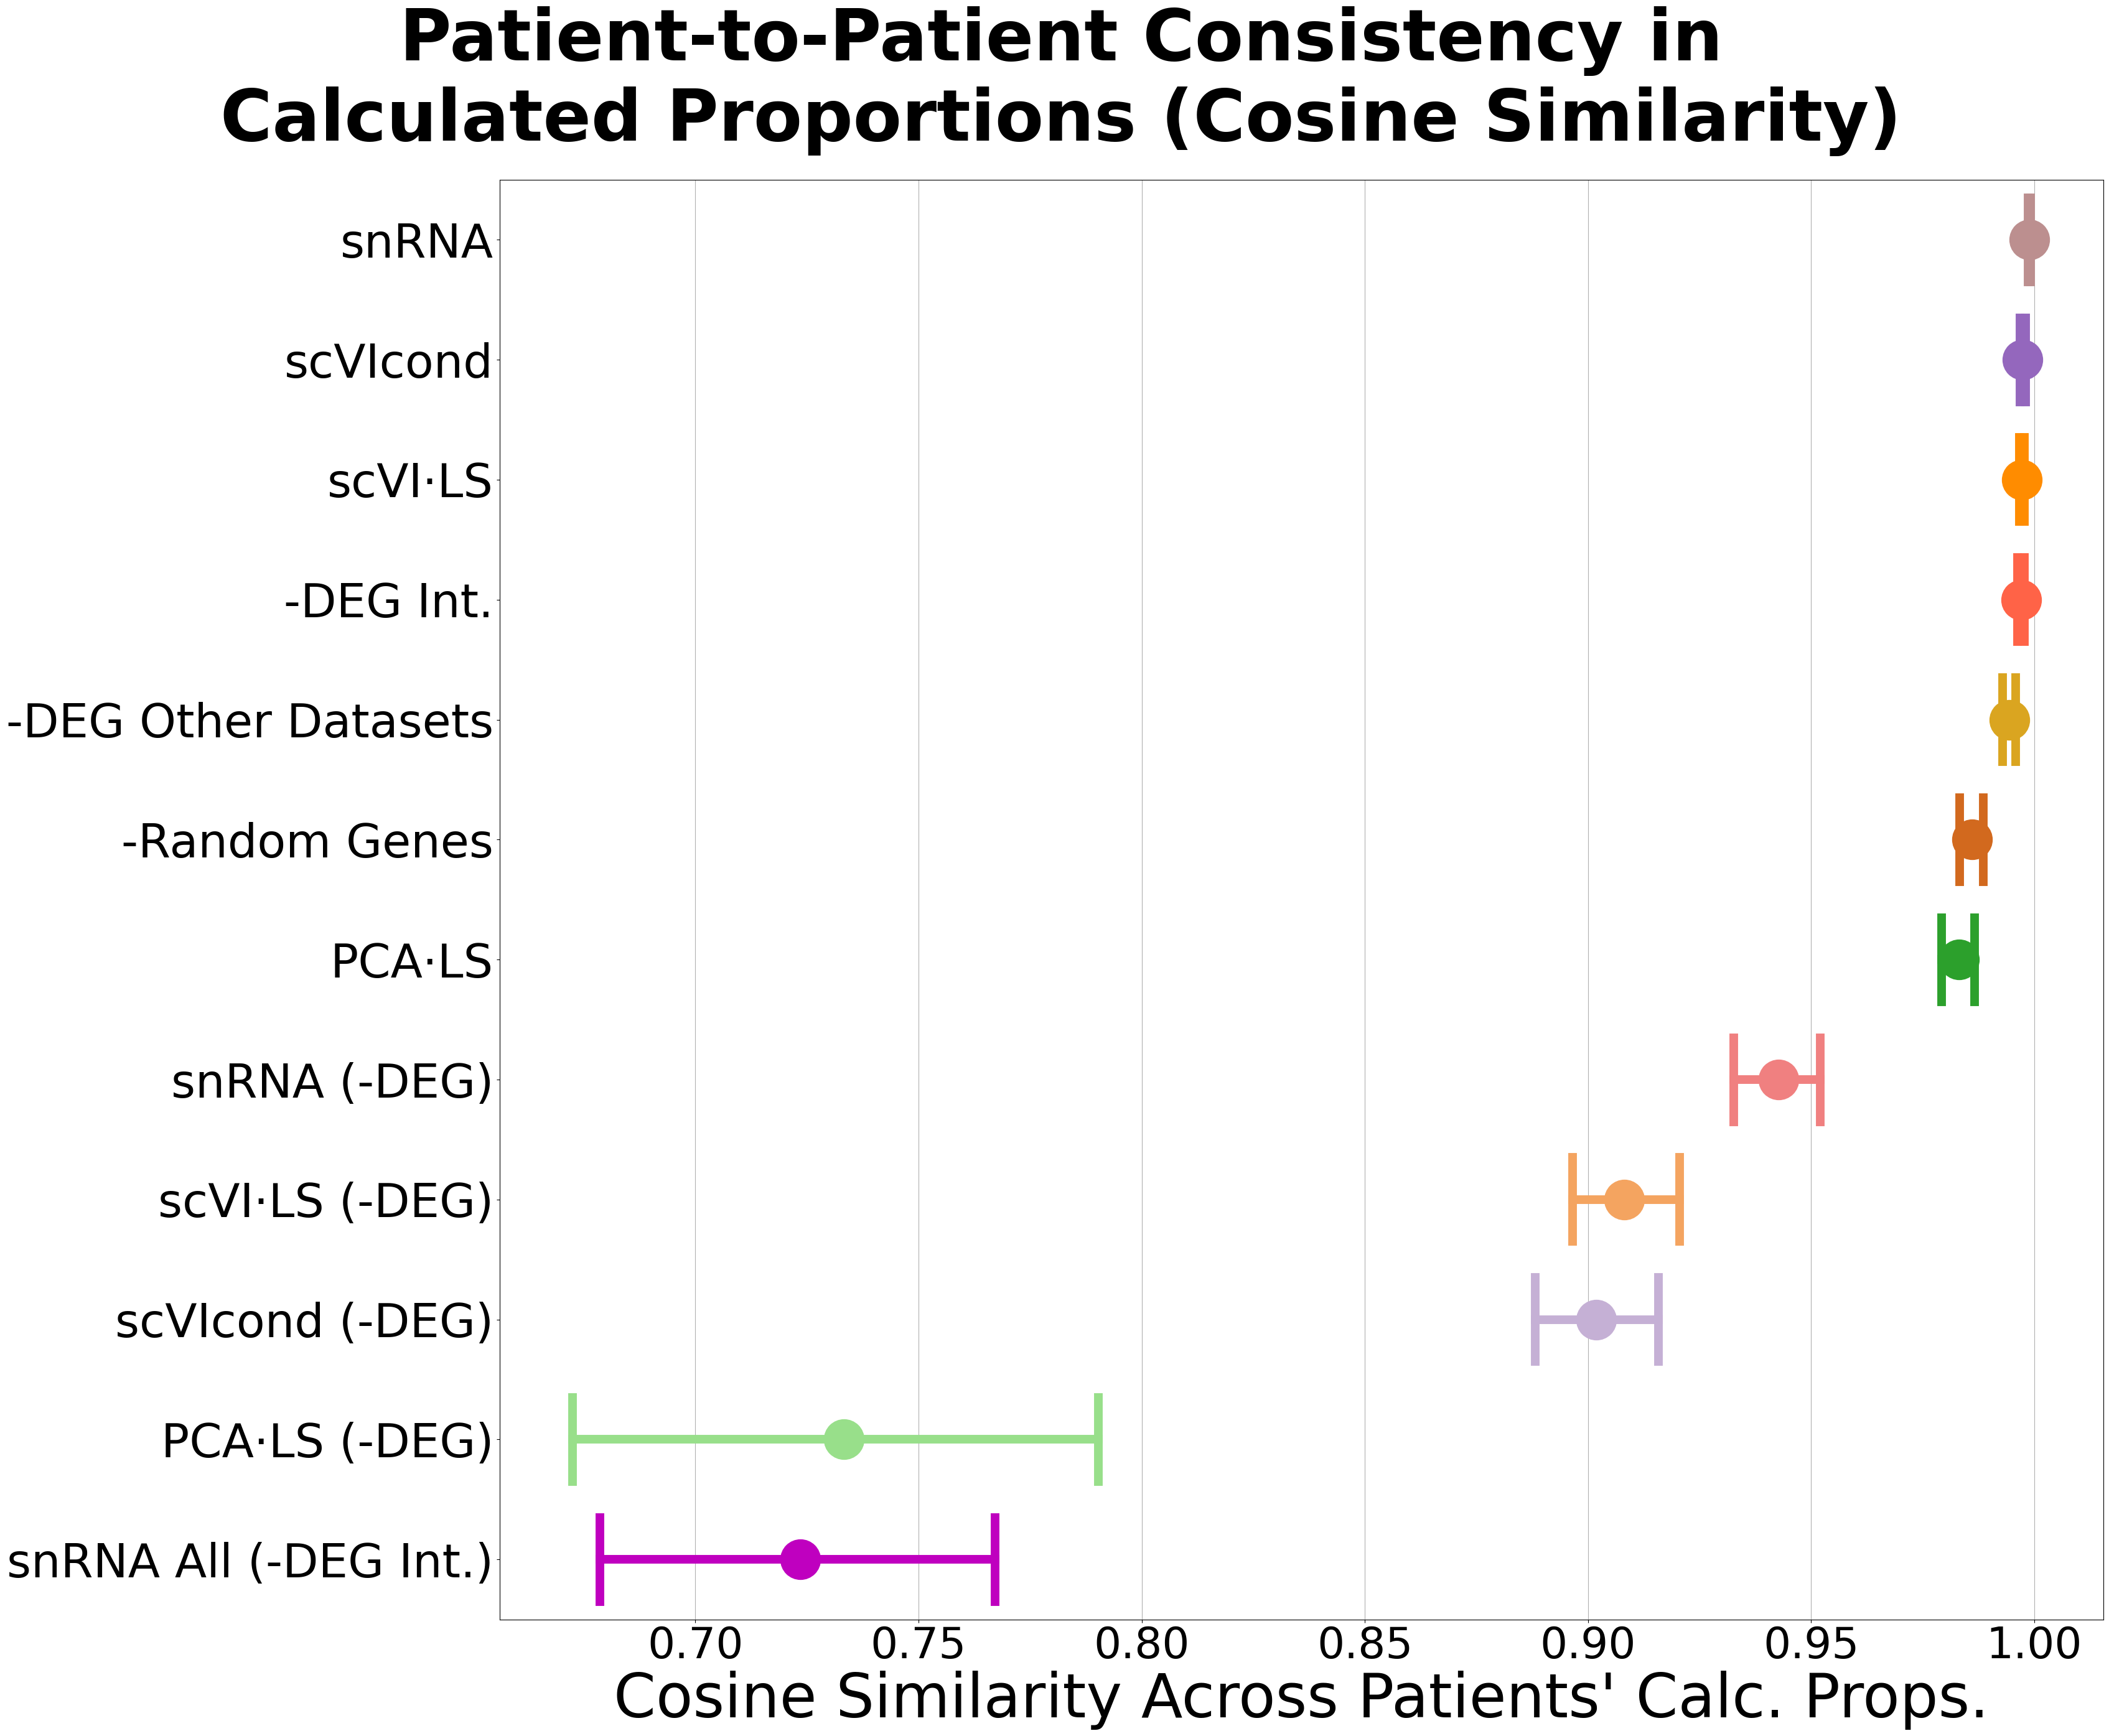

In [9]:
# compute the mean per Display and sort descending
mean_order = (
    df_donor_consistency.groupby("Display")["Cosine"]
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# pass that into your pointplot
plt.figure(figsize=(34, 28))
ax = sns.pointplot(
    y="Display",
    x="Cosine",
    data=df_donor_consistency,
    order=mean_order, 
    hue="Display",
    palette=display_palette,
    estimator=np.mean,
    errorbar=('ci', 95),
    n_boot=1000,
    linestyle='none',
    capsize=0.7,
    legend=False, 
    err_kws={'linewidth': 10},
    marker="o",
    markersize=45,
)

ax.set_xlabel("Cosine Similarity Across Patients' Calc. Props.", fontsize=70)
ax.xaxis.grid(True)
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=50)
ax.tick_params(axis='y', labelsize=54)
ax.set_title(
    "Patient-to-Patient Consistency in\nCalculated Proportions (Cosine Similarity)",
    fontsize=82,
    fontweight="bold",
    pad=45,
    x=0.35,
)
plt.tight_layout()
plt.show()

## Scatter: each point is a transform, x = donor‐consistency, y = inter‐transform consistency

In [10]:
# load the two summaries saved before.
sum_df = pd.read_csv(
    os.path.join("..", "results", dataset, f"transform_{method}_consistency_summary.csv"),
    index_col=0,
)
if "degpcaSN" in sum_df.index:
    sum_df.loc["degPCA_SN"] = sum_df.loc["degpcaSN"]
    sum_df.drop("degpcaSN", axis=0)

# compute mean donor‐consistency
mean_donor = df_donor_consistency.groupby("Transform")["Cosine"].mean()

# combine into one DataFrame
df_scatter = pd.DataFrame(
    {
        "Transform": mean_donor.index,
        "DonorSim": mean_donor.values,
        "TransSim": sum_df.loc[mean_donor.index, "mean_sim"].values,
    }
)
df_scatter["Display"] = df_scatter["Transform"].map(transform_mapping)
df_scatter["Transform"] = df_scatter.Display

df_scatter

,Transform,DonorSim,TransSim,Display
0,snRNA All (-DEG Int.),0.723493,0.364347,snRNA All (-DEG Int.)
1,-DEG Int.,0.997047,0.781641,-DEG Int.
2,-DEG Other Datasets,0.994489,0.674450,-DEG Other Datasets
3,PCA·LS (-DEG),0.733214,0.446720,PCA·LS (-DEG)
4,-Random Genes,0.986082,0.722746,-Random Genes
5,snRNA (-DEG),0.942643,0.748527,snRNA (-DEG)
6,scVI·LS (-DEG),0.908119,0.708084,scVI·LS (-DEG)
7,scVIcond (-DEG),0.901793,0.757882,scVIcond (-DEG)
8,PCA·LS,0.983204,0.747113,PCA·LS
9,snRNA,0.998927,0.744221,snRNA


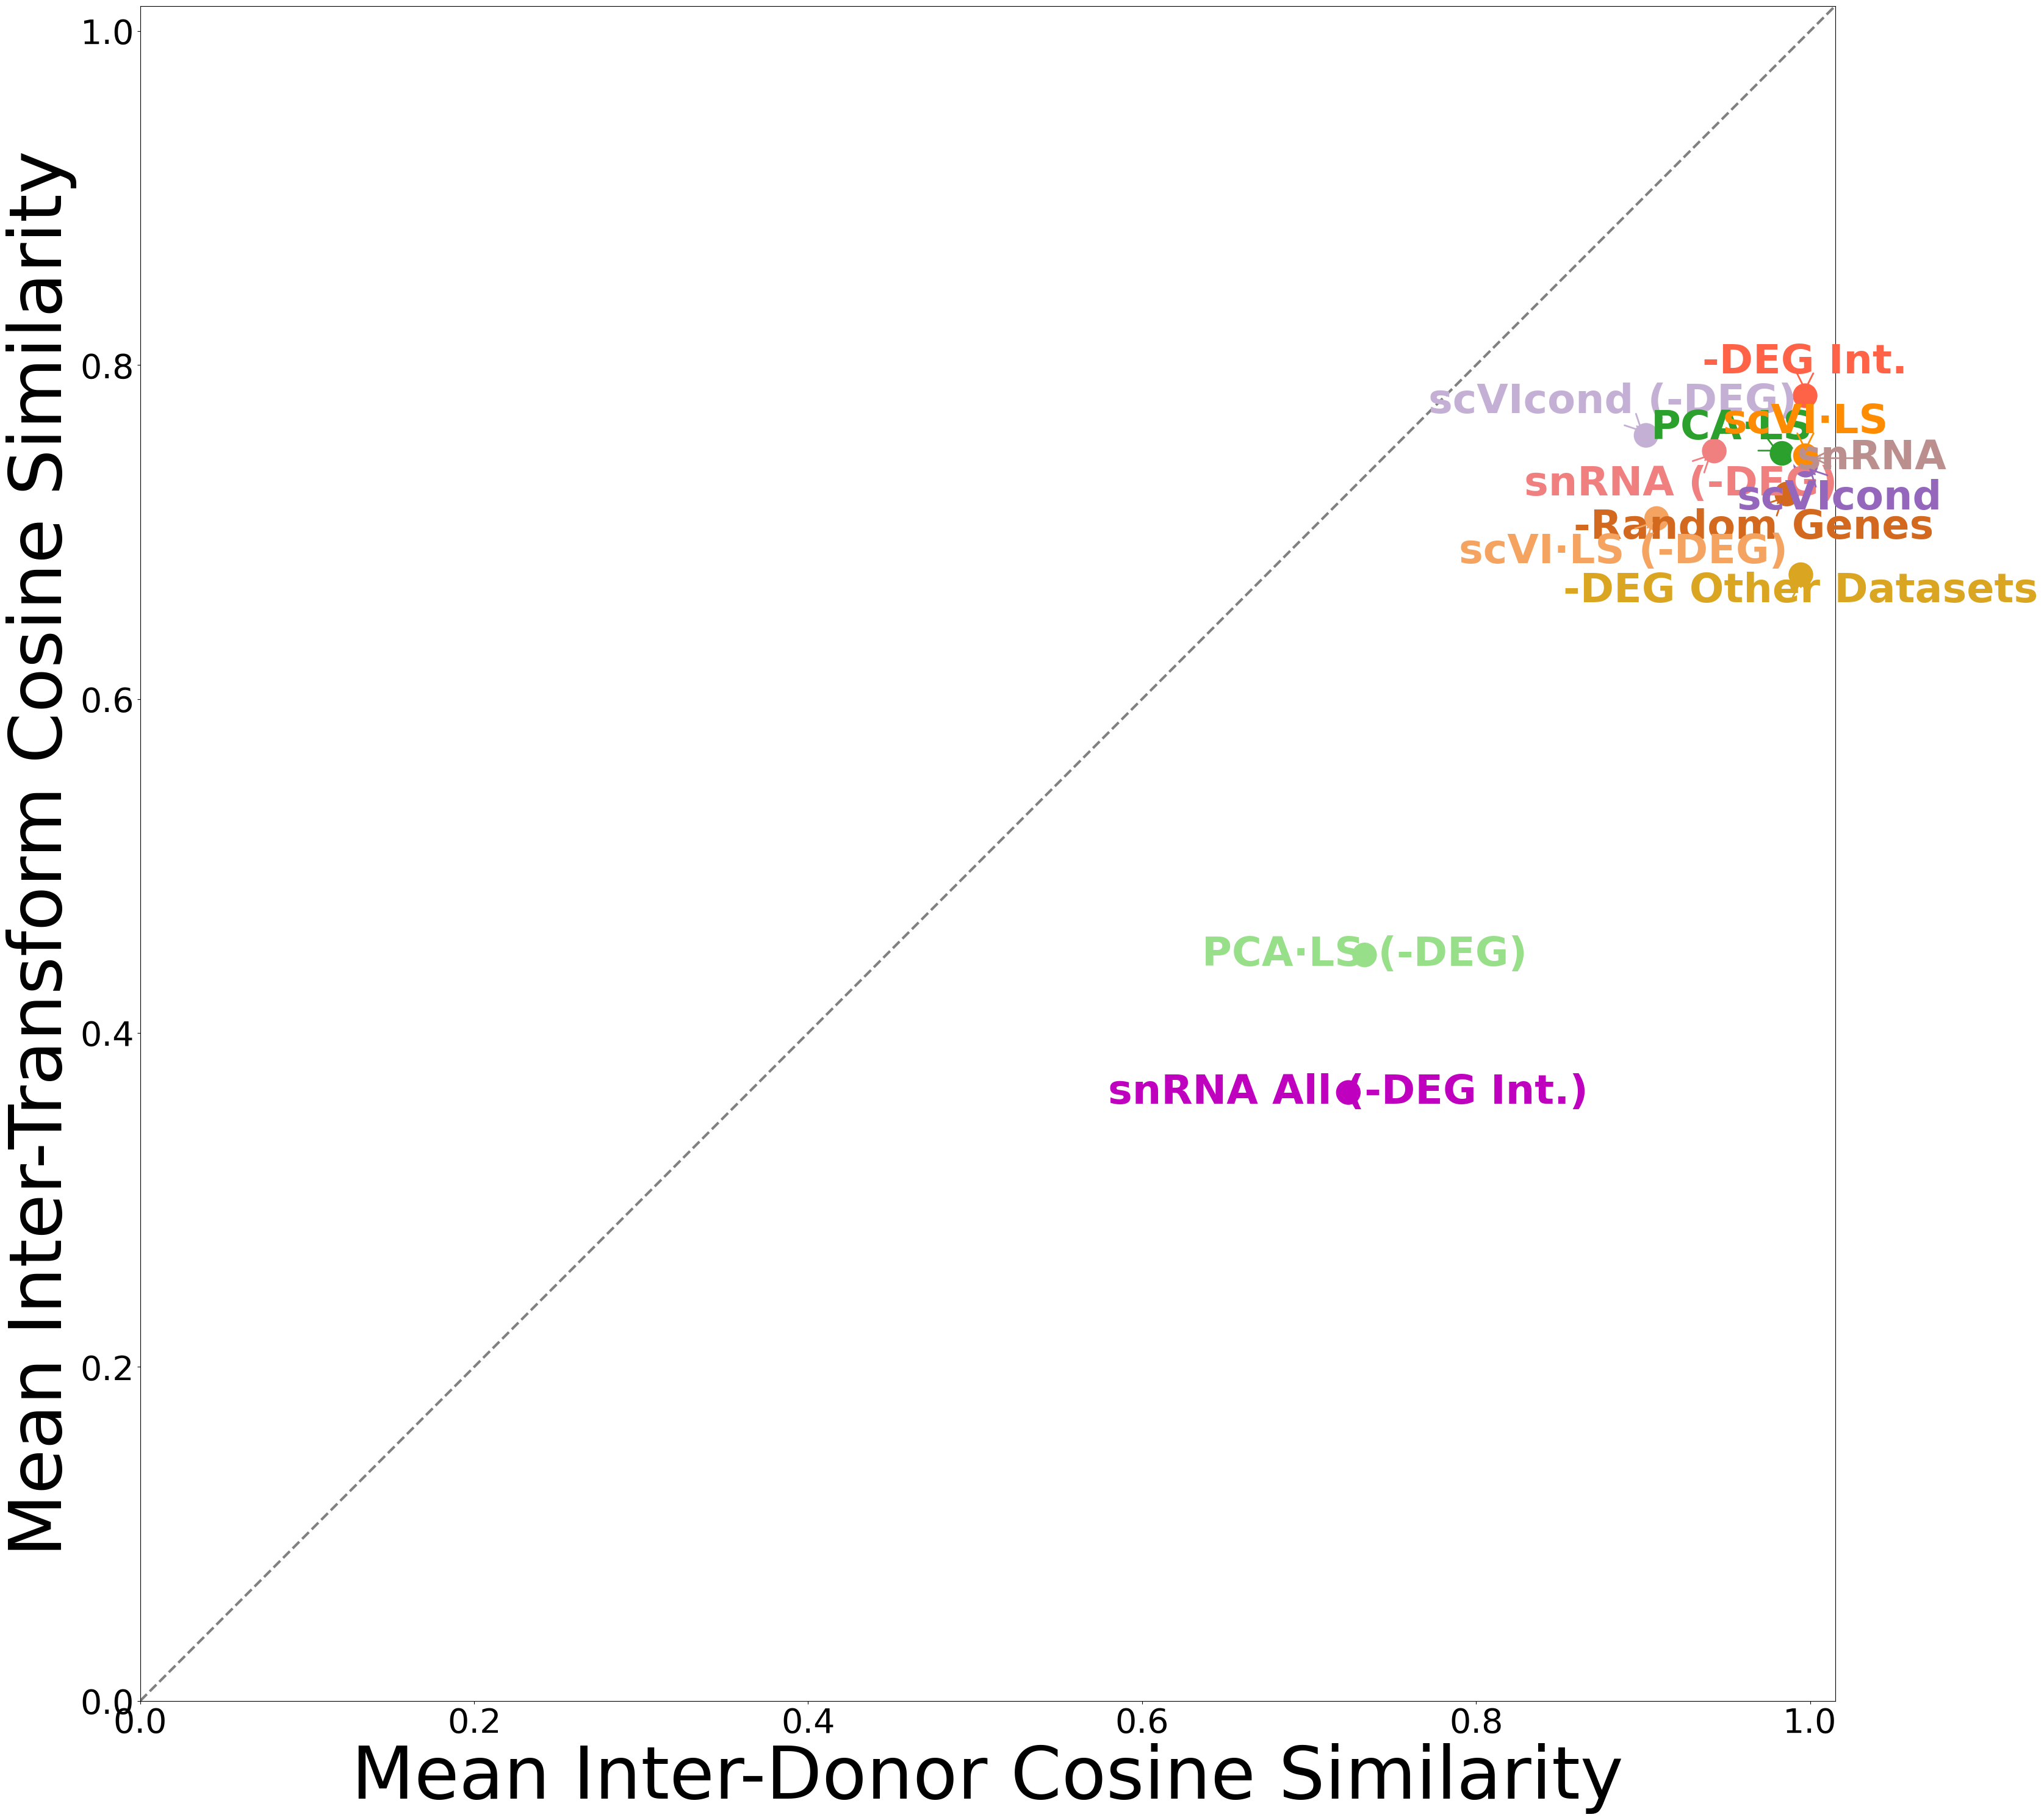

In [11]:
# define default text‐offsets for each label
if method == "BayesPrism":
    text_offsets = {
        "snRNA": (0.038, 0),
        "snRNA (-DEG)": (-0.02, -0.02),
        "-DEG Int.": (0, 0.02),
        "-DEG Other Datasets": (0, -0.01),
        "-Random Genes": (-0.02, -0.02),
        "PCA·LS": (-0.03, 0.015),
        "PCA·LS (-DEG)": (0, 0),
        "scVI·LS": (0, 0.02),
        "scVI·LS (-DEG)": (-0.02, -0.02),
        "scVIcond": (0.02, -0.02),
        "scVIcond (-DEG)": (-0.02, 0.02),
        "snRNA All (-DEG Int.)": (0, 0),
    }
    val_plot_1,val_plot_2 = [0, 1.015],[0, 1.015]
elif method == "SCDC":
    text_offsets = {
        "snRNA": (0.038, 0),
        "snRNA (-DEG)": (-0.02, -0.02),
        "-DEG Int.": (0, 0.02),
        "-DEG Other Datasets": (0, -0.01),
        "-Random Genes": (0.02, 0.02),
        "PCA": (-0.02, 0.02),
        "PCA (-DEG)": (0, 0),
        "scVILS": (0, 0.02),
        "scVILS (-DEG)": (-0.02, -0.02),
        "scVIcond": (0.02, -0.02),
        "scVIcond (-DEG)": (-0.02, 0.02),
        "snRNA All (-DEG Int.)": (0, 0),
    }
    val_plot_1,val_plot_2 = [0.425, 1.015],[0.425, 1.015]
elif method == "SCADEN":
    text_offsets = {
        "snRNA": (0, 0.04),
        "snRNA (-DEG)": (-0.02, 0.02),
        "-DEG Int.": (0.02, -0.02),
        "-DEG Other Datasets": (0, -0.02),
        "-Random Genes": (0.02, 0.04),
        "PCA·LS": (0, 0.02),
        "PCA·LS (-DEG)": (-0.085, 0),
        "scVI·LS": (0, -0.02),
        "scVI·LS (-DEG)": (-0.085, 0),
        "scVIcond": (0.02, -0.02),
        "scVIcond (-DEG)": (-0.02, 0.02),
        "snRNA All (-DEG Int.)": (0, -0.02),
    }
    val_plot_1,val_plot_2 = [0.2, 1.015],[.2, 1.015]


plt.figure(figsize=(32, 30))
ax = sns.scatterplot(
    x="DonorSim",
    y="TransSim",
    hue="Display",
    data=df_scatter,
    palette=display_palette,
    s=1000,
    legend=False,
)

# annotate each point with its label at the offset, arrow in same color
for _, row in df_scatter.iterrows():
    label = row["Display"]
    x, y = row["DonorSim"], row["TransSim"]
    dx, dy = text_offsets.get(label, (0.05, 0.05))  # fallback offset

    ax.annotate(
        label,
        xy=(x, y),  # point coordinates
        xytext=(x + dx, y + dy),  # label coordinates
        textcoords="data",
        ha="center",
        va="center",
        fontsize=48,
        color=display_palette[label],
        weight="bold",
        arrowprops=dict(
            arrowstyle="->", color=display_palette[label], lw=2, shrinkA=5, shrinkB=5
        ),
    )

ax.set_aspect("equal", adjustable="box")
ax.plot(val_plot_1, val_plot_2, "--", linewidth=3, color="gray")
ax.set_xlabel("Mean Inter-Donor Cosine Similarity", fontsize=86)
ax.set_ylabel("Mean Inter-Transform Cosine Similarity", fontsize=86)
ax.tick_params(axis="both", which="major", labelsize=40)
ax.set_ylim(val_plot_1)
ax.set_xlim(val_plot_2)
plt.tight_layout()
plt.show()

The above plot shows all transforms with axes 0 to 1. This makes it very difficult to note any differences etc. We'll cut the axes and make the 2 outlier be dotted lines entering plot instead: (same data)

In [12]:
df_scatter

,Transform,DonorSim,TransSim,Display
0,snRNA All (-DEG Int.),0.723493,0.364347,snRNA All (-DEG Int.)
1,-DEG Int.,0.997047,0.781641,-DEG Int.
2,-DEG Other Datasets,0.994489,0.674450,-DEG Other Datasets
3,PCA·LS (-DEG),0.733214,0.446720,PCA·LS (-DEG)
4,-Random Genes,0.986082,0.722746,-Random Genes
5,snRNA (-DEG),0.942643,0.748527,snRNA (-DEG)
6,scVI·LS (-DEG),0.908119,0.708084,scVI·LS (-DEG)
7,scVIcond (-DEG),0.901793,0.757882,scVIcond (-DEG)
8,PCA·LS,0.983204,0.747113,PCA·LS
9,snRNA,0.998927,0.744221,snRNA


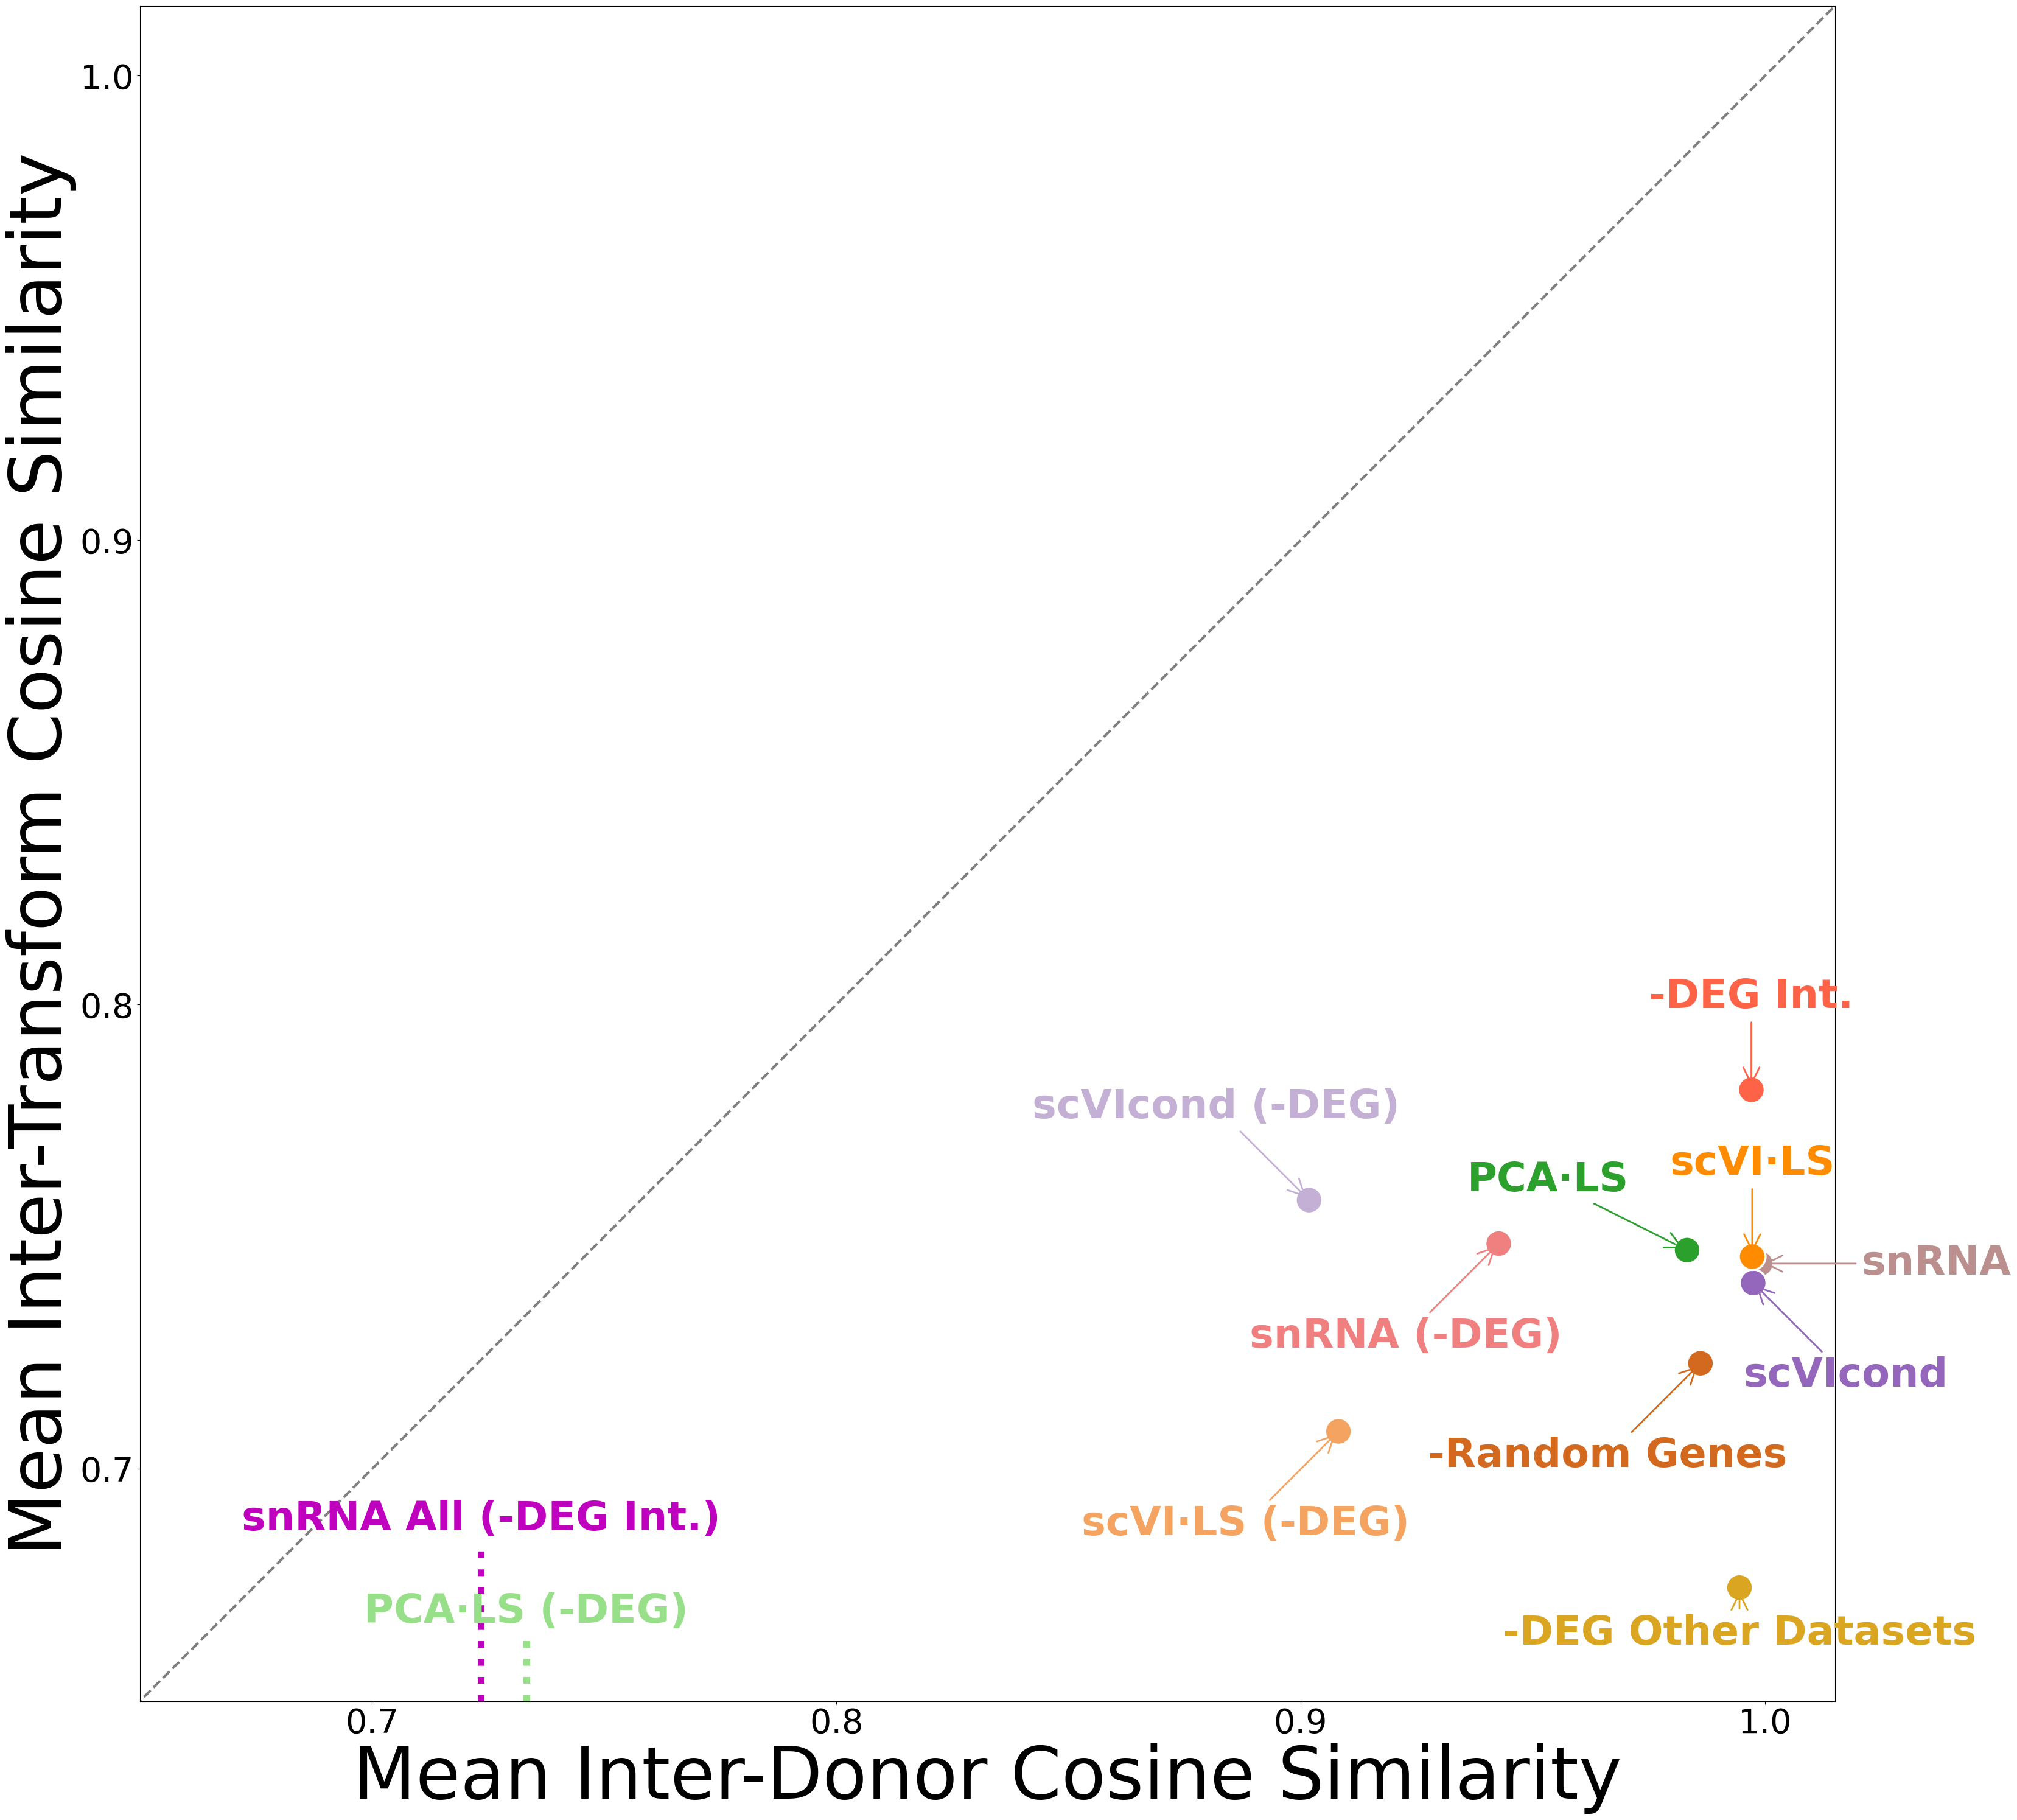

In [13]:
if method == "BayesPrism":
    POINT_SIZE = 1000
    LABEL_SIZE = 48
    DOT_LINEWIDTH = 2
    AXIS_TITLE_SIZE = 86
    TICK_SIZE = 40

    off_label_offsets = {
        "PCA·LS (-DEG)": 0.015,  # higher
        "snRNA All (-DEG Int.)": 0.035,  # lower
    }
    # --------------------------------------------------
    # make the base scatter of ALL in-frame points
    # --------------------------------------------------
    off_frame = ["PCA·LS (-DEG)", "snRNA All (-DEG Int.)"]
    df_in = df_scatter[~df_scatter.Display.isin(off_frame)]
    df_off = df_scatter[df_scatter.Display.isin(off_frame)]

    plt.figure(figsize=(32, 30))
    ax = sns.scatterplot(
        data=df_in,
        x="DonorSim",
        y="TransSim",
        hue="Display",
        palette=display_palette,
        s=POINT_SIZE,
        legend=False,
    )

    # --------------------------------------------------
    # annotate the in-frame dots with original offsets
    # --------------------------------------------------
    for _, row in df_in.iterrows():
        lbl = row["Display"]
        x, y = row["DonorSim"], row["TransSim"]
        dx, dy = text_offsets.get(lbl, (0.05, 0.05))
        ax.annotate(
            lbl,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            ha="center",
            va="center",
            fontsize=LABEL_SIZE,
            weight="bold",
            color=display_palette[lbl],
            arrowprops=dict(
                arrowstyle="->",
                color=display_palette[lbl],
                lw=DOT_LINEWIDTH,
                shrinkA=5,
                shrinkB=5,
            ),
        )

    # --------------------------------------------------
    #  add dotted guide + label for the two off-frame pts
    # --------------------------------------------------
    y_bottom = 0.65
    for _, row in df_off.iterrows():
        lbl = row["Display"]
        x_pos = row["DonorSim"]
        dy = off_label_offsets[lbl]  # label-specific lift

        # dotted stub
        ax.plot(
            [x_pos, x_pos],
            [y_bottom, y_bottom + dy - 0.0005],  # stub ends a bit below label
            linestyle=":",
            lw=DOT_LINEWIDTH * 4,
            color=display_palette[lbl],
        )

        # label
        ax.text(
            x_pos,
            y_bottom + dy,
            lbl,
            ha="center",
            va="bottom",
            fontsize=LABEL_SIZE,
            weight="bold",
            color=display_palette[lbl],
        )
    # --------------------------------------------------
    # cosmetics
    # --------------------------------------------------
    ax.set_aspect("equal", adjustable="box")
    ax.plot([0, 1.015], [0, 1.015], "--", lw=3, color="gray")

    ax.set_xlabel("Mean Inter-Donor Cosine Similarity", fontsize=AXIS_TITLE_SIZE)
    ax.set_ylabel("Mean Inter-Transform Cosine Similarity", fontsize=AXIS_TITLE_SIZE)
    ax.tick_params(axis="both", labelsize=TICK_SIZE)

    ax.set_xlim(0.65, 1.015)
    ax.set_ylim(0.65, 1.015)
    ax.set_xticks([0.7, 0.8, 0.9, 1.0])
    ax.set_yticks([0.7, 0.8, 0.9, 1.0])

    plt.tight_layout()
    plt.show()

## Heatmap of cosine similairities for inter-patient cells

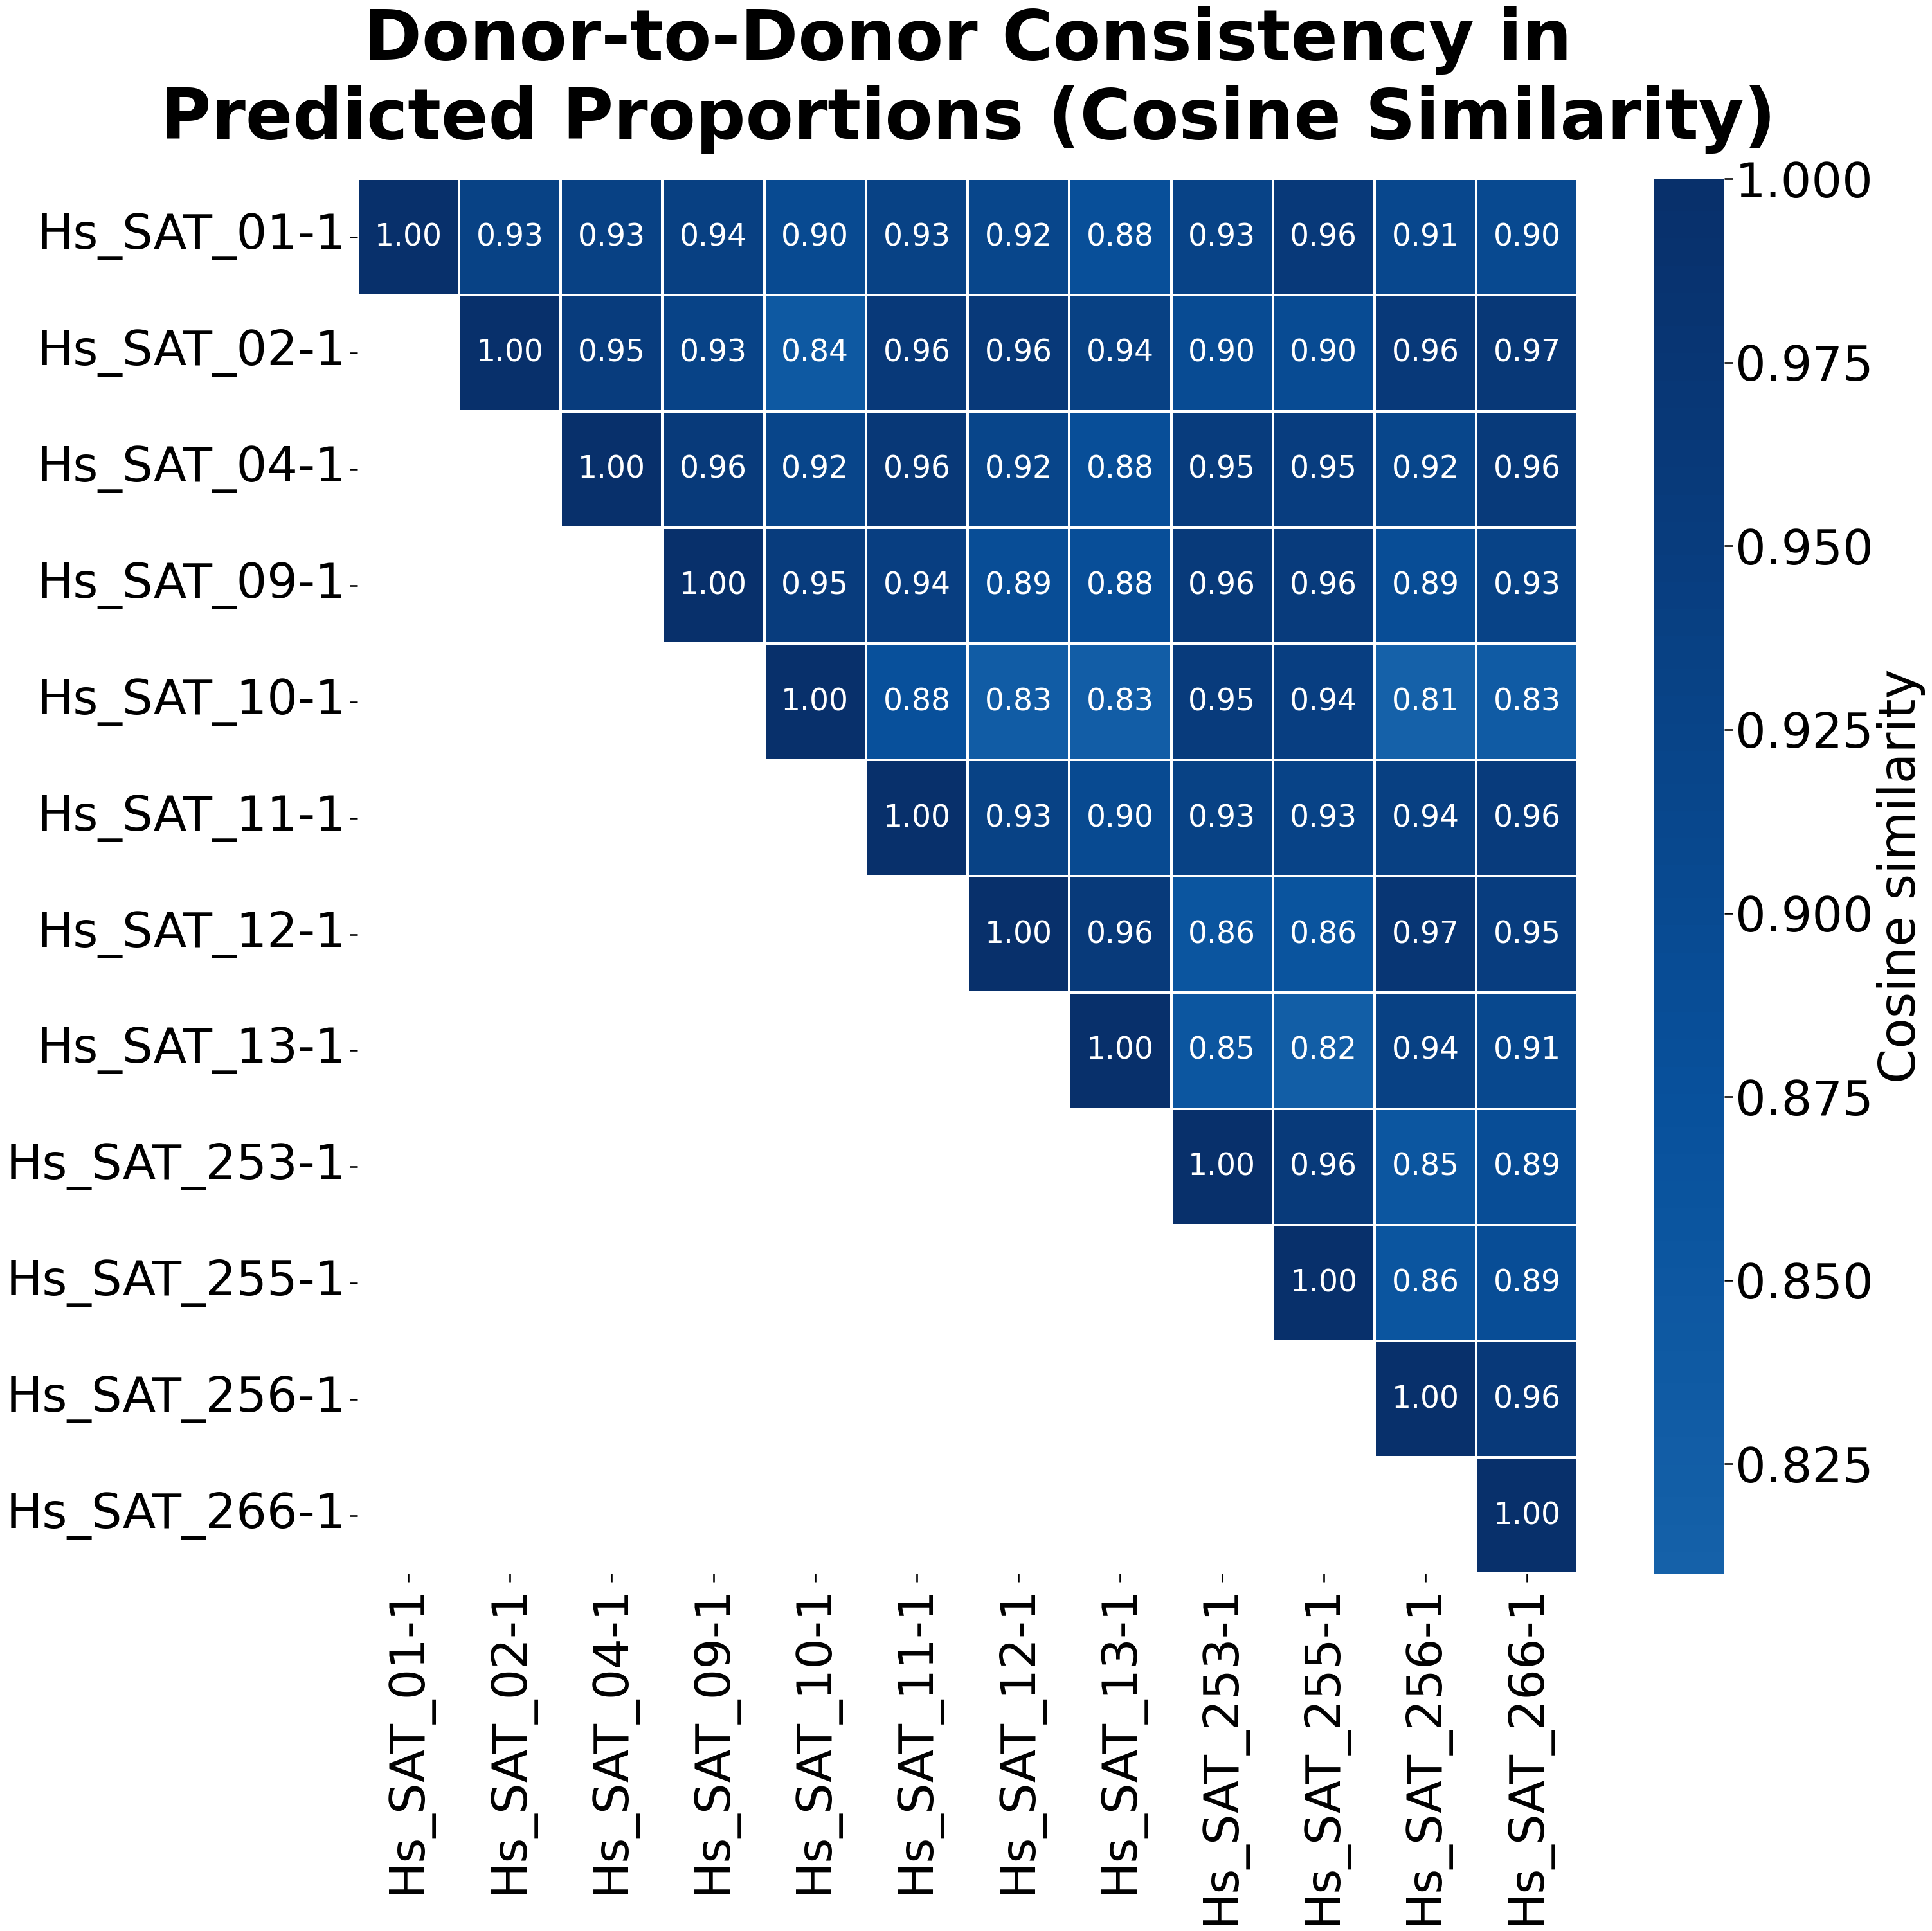

In [14]:
# List of donors (will be both rows and columns)
donors = sorted(df_pd["Donor"].unique())

# Build a flattened vector for each donor:
donor_vec = {}
for d in donors:
    sub = df_pd[df_pd["Donor"] == d]
    mat = (
        sub.pivot_table(
            index="SampleID", columns=["Transform", "CellType"], values="PredProp"
        )
        .sort_index()
        .sort_index(axis=1)
    )
    donor_vec[d] = mat.values.ravel()

# Compute pairwise cosine similarities
corr = pd.DataFrame(index=donors, columns=donors, dtype=float)
for d1 in donors:
    for d2 in donors:
        corr.loc[d1, d2] = cosine_similarity(
            donor_vec[d1].reshape(1, -1), donor_vec[d2].reshape(1, -1)
        )[0, 0]

# Plot in the same style as your transform heatmap
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
sns.set_context("talk", font_scale=4)
fig, ax = plt.subplots(figsize=(32, 32))
palette = sns.color_palette("Blues", as_cmap=True)

sns.heatmap(
    corr.astype(float),
    mask=mask,
    cmap=palette,
    center=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 34},
    linewidths=1.5,
    cbar_kws={"label": "Cosine similarity"},
    xticklabels=donors,
    yticklabels=donors,
    ax=ax,
)

# Ticks and labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=54)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=54)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=54)
cbar.set_label("Cosine similarity", fontsize=56)

# Title
ax.set_title(
    "Donor-to-Donor Consistency in\nPredicted Proportions (Cosine Similarity)",
    fontsize=78,
    pad=45,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

In [15]:
# df_donor_consistency has one row per (Transform, Donor1–Donor2, Cosine)
df_donor_consistency.to_csv(
    os.path.join(results_dir, f"donor_{method}_pairwise_consistency.csv"), index=False
)
df_donor_consistency

,Transform,Cosine,Display
0,degIntAllSN,0.820101,snRNA All (-DEG Int.)
1,degIntAllSN,0.591809,snRNA All (-DEG Int.)
2,degIntAllSN,0.625196,snRNA All (-DEG Int.)
3,degIntAllSN,0.452143,snRNA All (-DEG Int.)
4,degIntAllSN,0.791313,snRNA All (-DEG Int.)
...,...,...,...
787,scvi_LSshift_SN,0.995944,scVI·LS
788,scvi_LSshift_SN,0.995043,scVI·LS
789,scvi_LSshift_SN,0.999981,scVI·LS
790,scvi_LSshift_SN,0.999929,scVI·LS
